# ZMYM3
[X-linked intellectual developmental disorder-112 (XLID112)](https://omim.org/entry/301111) is caused by hemizygous or heterozygous mutation in the ZMYM3 gene.

In [1]:
import hpotk
import gpsea

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo(release='v2024-08-13')
print(f'Loaded HPO v{hpo.version}')
print(f"Using gpsea version {gpsea.__version__}")

Loaded HPO v2024-08-13
Using gpsea version 0.7.1.dev0


### ZMYM3
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for ZMYM3.

In [2]:
gene_symbol = 'ZMYM3'
mane_tx_id = 'NM_201599.3'
mane_protein_id = 'NP_963893.1' # zinc finger MYM-type protein 3 isoform 1 [Homo sapiens]

In [3]:
from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.21") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
print(f'Loaded {len(phenopackets)} phenopackets')

from pyphetools.visualization import PhenopacketIngestor
ingestor = PhenopacketIngestor(indir="../../../phenopacket-store/notebooks/ZMYM3/phenopackets")
phenopackets = ingestor.get_phenopacket_list()
print(f'Loaded {len(phenopackets)} phenopackets')


from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets
cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(  
    phenopackets=phenopackets,
    cohort_creator=cohort_creator,
)
validation.summarize()

Loaded 29 phenopackets
[pyphetools] Ingested 33 GA4GH phenopackets.
Loaded 33 phenopackets
Individuals Processed: 100%|██████████| 33/33 [00:00<00:00, 126.17individuals/s]
Validated under permissive policy
Showing errors and warnings
Phenopackets
  patient #0
    phenotype-features
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #1
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #2
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #5
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_class`
  patient #6
    diseases
      #0
       warnings:
       ·`time_element` is in currently unsupported format `ontology_c

In [4]:
from gpsea.view import CohortViewer

cv = CohortViewer(hpo)
cv.process(cohort, transcript_id=mane_tx_id)

HPO Term,ID,Seen in n individuals
Delayed speech and language development,HP:0000750,29
Motor delay,HP:0001270,21
Intellectual disability,HP:0001249,20
Autistic behavior,HP:0000729,15
Hypospadias,HP:0000047,8
Cupped ear,HP:0000378,8
Short stature,HP:0004322,7
Sleep abnormality,HP:0002360,6
Deeply set eye,HP:0000490,6
Microcephaly,HP:0000252,6


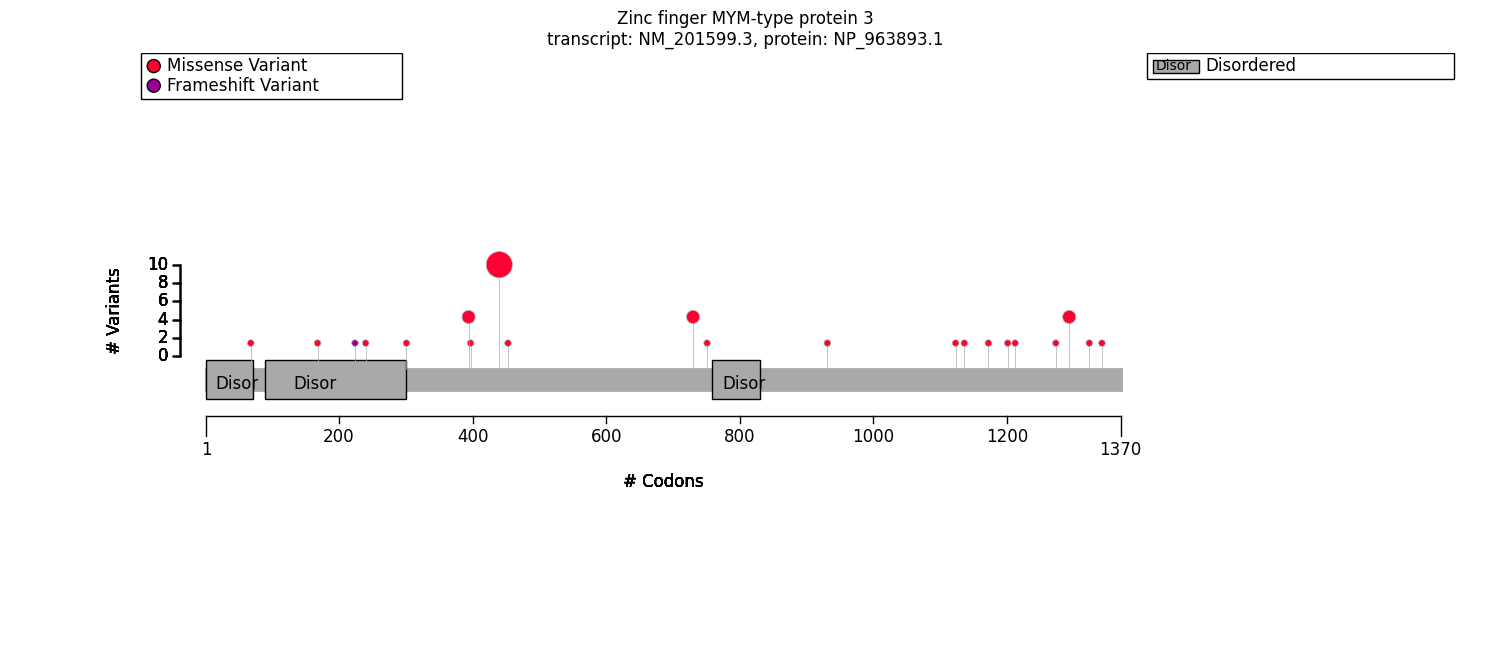

In [5]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import configure_default_protein_metadata_service, VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt

txc_service = VVMultiCoordinateService(genome_build=GRCh38)
pms = configure_default_protein_metadata_service()
tx_coordinates = txc_service.fetch(mane_tx_id)
protein_meta = pms.annotate(mane_protein_id)


fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
fig.tight_layout()

In [6]:
from gpsea.analysis.predicate.phenotype import prepare_predicates_for_terms_of_interest
from gpsea.analysis.pcats.stats import FisherExactTest
from gpsea.analysis.mtc_filter import HpoMtcFilter
from gpsea.analysis.pcats import HpoTermAnalysis

pheno_predicates = prepare_predicates_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

mtc_filter = HpoMtcFilter.default_filter(hpo=hpo, term_frequency_threshold=0.2)
mtc_correction = 'fdr_bh'
statistic = FisherExactTest()

analysis = HpoTermAnalysis(
    count_statistic=statistic,
    mtc_filter=mtc_filter,
    mtc_correction=mtc_correction,
    mtc_alpha=0.05,
)

In [7]:
from gpsea.model.genome import Region

from gpsea.analysis.predicate.genotype import VariantPredicates, monoallelic_predicate

n_term = VariantPredicates.region(region=Region(1, 600), tx_id=mane_tx_id)
gt_predicate = monoallelic_predicate(
    a_predicate=n_term,
    b_predicate=~n_term,
    a_label="N term",
    b_label="other"
)
nterm_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=gt_predicate,
    pheno_predicates=pheno_predicates,
)
from gpsea.view import MtcStatsViewer

viewer = MtcStatsViewer()
viewer.process(nterm_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.2,43
HMF03,Skipping term because of a child term with the same individual counts,6
HMF08,Skipping general term,83
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,149


In [8]:
from gpsea.view import summarize_hpo_analysis

summarize_hpo_analysis(hpo=hpo, result=nterm_result)

Allele group                                       N term          other  \
                                                    Count Percent  Count   
Hypospadias [HP:0000047]                             8/19     42%   0/13   
Cupped ear [HP:0000378]                              7/19     37%   1/14   
Abnormal aortic valve cusp morphology [HP:0031567]   4/16     25%   0/14   
Bicuspid aortic valve [HP:0001647]                   4/18     22%   0/14   
Short stature [HP:0004322]                           5/13     38%   2/14   
Low-set ears [HP:0000369]                            1/16      6%   3/14   
Motor delay [HP:0001270]                            13/16     81%   8/13   
Enuresis [HP:0000805]                                3/15     20%   1/13   
Thin vermilion border [HP:0000233]                   2/16     12%   3/14   
Microcephaly [HP:0000252]                            2/13     15%   4/14   
Autistic behavior [HP:0000729]                       9/13     69%   6/11   
Intellectual disability [HP:0001249]                14/16     88%   9/10   
Neurodevelopmental abnormality [HP:0012759]         19/19    100%  13/13   
Atypical behavior [HP:0000708]                      14/16     88%  10/11   
Neurodevelopmental delay [HP:0012758]               16/16    100%  13/13   
Delayed speech and language development [HP:000...  16/16    100%  13/13   
Abnormal communication [HP:0034434]                 16/16    100%  13/13   
Diagnostic behavioral phenotype [HP:0025783]         9/11     82%    6/7   
Deeply set eye [HP:0000490]                          3/16     19%   3/14   

Allele group                                                                   \
                                                   Percent Corrected p values   
Hypospadias [HP:0000047]                                0%           0.197749   
Cupped ear [HP:0000378]                                 7%           0.536422   
Abnormal aortic valve cusp morphology [HP:0031567]      0%           0.536422   
Bicuspid aortic valve [HP:0001647]                      0%           0.536422   
Short stature [HP:0004322]                             14%           0.793043   
Low-set ears [HP:0000369]                              21%           0.998936   
Motor delay [HP:0001270]                               62%           1.000000   
Enuresis [HP:0000805]                                   8%           1.000000   
Thin vermilion border [HP:0000233]                     21%           1.000000   
Microcephaly [HP:0000252]                              29%           1.000000   
Autistic behavior [HP:0000729]                         55%           1.000000   
Intellectual disability [HP:0001249]                   90%           1.000000   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Atypical behavior [HP:0000708]                         91%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Delayed speech and language development [HP:000...    100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Diagnostic behavioral phenotype [HP:0025783]           86%           1.000000   
Deeply set eye [HP:0000490]                            21%           1.000000   

Allele group                                                  
                                                    p values  
Hypospadias [HP:0000047]                            0.010408  
Cupped ear [HP:0000378]                             0.098151  
Abnormal aortic valve cusp morphology [HP:0031567]  0.102937  
Bicuspid aortic valve [HP:0001647]                  0.112931  
Short stature [HP:0004322]                          0.208696  
Low-set ears [HP:0000369]                           0.315453  
Motor delay [HP:0001270]                            0.405764  
Enuresis [HP:0000805]                               0.600000  
Thin vermilion border [HP:0000233]                  0.642401  
Microcep

In [9]:
r441w = VariantPredicates.variant_key("X_71249610_71249610_G_A") #c.1321C>T	p.Arg441Trp
r441q = VariantPredicates.variant_key("X_71249609_71249609_C_T") #c.1322G>A	p.Arg441Gln	
r441 = r441w | r441q

is_r441 = monoallelic_predicate(
    a_predicate=r441,
    b_predicate=~r441,
    a_label="R441",
    b_label="other"
)
r441_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_predicate=is_r441,
    pheno_predicates=pheno_predicates,
)
summarize_hpo_analysis(hpo=hpo, result=r441_result)

Allele group                                         R441          other  \
                                                    Count Percent  Count   
Cupped ear [HP:0000378]                              7/10     70%   1/23   
Abnormal aortic valve cusp morphology [HP:0031567]    4/8     50%   0/22   
Hypospadias [HP:0000047]                             6/10     60%   2/22   
Bicuspid aortic valve [HP:0001647]                   4/10     40%   0/22   
Enuresis [HP:0000805]                                 3/6     50%   1/22   
Short stature [HP:0004322]                            3/4     75%   4/23   
Enuresis nocturna [HP:0010677]                        2/6     33%   0/21   
Triangular face [HP:0000325]                          2/7     29%   0/23   
Autistic behavior [HP:0000729]                        4/4    100%  11/20   
Intellectual disability [HP:0001249]                10/10    100%  13/16   
Atypical behavior [HP:0000708]                        8/8    100%  16/19   
Microcephaly [HP:0000252]                             0/4      0%   6/23   
Motor delay [HP:0001270]                              6/7     86%  15/22   
Neurodevelopmental abnormality [HP:0012759]         10/10    100%  22/22   
Neurodevelopmental delay [HP:0012758]                 7/7    100%  22/22   
Delayed speech and language development [HP:000...    7/7    100%  22/22   
Abnormal communication [HP:0034434]                   7/7    100%  22/22   
Diagnostic behavioral phenotype [HP:0025783]          4/4    100%  11/14   
Deeply set eye [HP:0000490]                           1/7     14%   5/23   

Allele group                                                                   \
                                                   Percent Corrected p values   
Cupped ear [HP:0000378]                                 4%           0.003839   
Abnormal aortic valve cusp morphology [HP:0031567]      0%           0.024266   
Hypospadias [HP:0000047]                                9%           0.027739   
Bicuspid aortic valve [HP:0001647]                      0%           0.027739   
Enuresis [HP:0000805]                                   5%           0.084444   
Short stature [HP:0004322]                             17%           0.114655   
Enuresis nocturna [HP:0010677]                          0%           0.114655   
Triangular face [HP:0000325]                            0%           0.114655   
Autistic behavior [HP:0000729]                         55%           0.496923   
Intellectual disability [HP:0001249]                   81%           0.496923   
Atypical behavior [HP:0000708]                         84%           0.863390   
Microcephaly [HP:0000252]                              26%           0.863390   
Motor delay [HP:0001270]                               68%           0.927995   
Neurodevelopmental abnormality [HP:0012759]           100%           1.000000   
Neurodevelopmental delay [HP:0012758]                 100%           1.000000   
Delayed speech and language development [HP:000...    100%           1.000000   
Abnormal communication [HP:0034434]                   100%           1.000000   
Diagnostic behavioral phenotype [HP:0025783]           79%           1.000000   
Deeply set eye [HP:0000490]                            22%           1.000000   

Allele group                                                  
                                                    p values  
Cupped ear [HP:0000378]                             0.000202  
Abnormal aortic valve cusp morphology [HP:0031567]  0.002554  
Hypospadias [HP:0000047]                            0.004867  
Bicuspid aortic valve [HP:0001647]                  0.005840  
Enuresis [HP:0000805]                               0.022222  
Short stature [HP:0004322]                          0.041880  
Enuresis nocturna [HP:0010677]                      0.042735  
Triangular face [HP:0000325]                        0.048276  
Autistic behavior [HP:0000729]                      0.258893  
Intellec

In [10]:
# Summary

In [11]:
from gpseacs.report import GPAnalysisResult, GpseaAnalysisReport, GPSEANotebookSummarizer

report_nterm = GPAnalysisResult.from_multi(result=nterm_result, )
report_r441 = GPAnalysisResult.from_multi(result=r441_result, interpretation="some sage advice")
report = GpseaAnalysisReport(name=gene_symbol, cohort=cohort, results=[report_nterm, report_r441], caption="something")

In [12]:
import io
out = io.StringIO()
summarizer = GPSEANotebookSummarizer(hpo=hpo)
summarizer.summarize_result(report, out)

In [13]:
out.getvalue()

'test'